I adapted this notebook template from `CleanCleanERwithoutGT.ipynb` on the `pyJedAI` GitHub into this NB. I added notes on things that worked and didn't work for me: [link to original notebook](https://github.com/AI-team-UoA/pyJedAI/blob/main/docs/tutorials/CleanCleanERwithoutGT.ipynb).

We don't have a ground-truth file, so we will have to explore ways to measure the validity of our results. We should do this before we optimize our code against our data set further. 

**Notes**: 
- I kept the original imports so that we can experiment with different methods/stages. I noted import errors that I ran into.
- There are some stages that I performed since they are technically listed as *optional*. Once we have metrics to measure the correctedness our entity relations

In [1]:
!pip install pyjedai

In [2]:
!pip show pyjedai

Name: pyjedai
Version: 0.1.3
Summary: An open-source library that builds powerful end-to-end Entity Resolution workflows.
Home-page: 
Author: 
Author-email: Konstantinos Nikoletos <nikoletos.kon@gmail.com>, George Papadakis <gpapadis84@gmail.com>, Jakub Maciejewski <jacobb.maciejewski@gmail.com>, Manolis Koubarakis <koubarak@di.uoa.gr>
License: Apache Software License 2.0
Location: /Users/javi/anaconda3/lib/python3.9/site-packages
Requires: faiss-cpu, gensim, matplotlib, matplotlib-inline, networkx, nltk, numpy, optuna, ordered-set, pandas, pandas-profiling, pandocfilters, plotly, py-stringmatching, PyYAML, rdflib, rdfpandas, regex, scipy, seaborn, sentence-transformers, strsim, strsimpy, tomli, tqdm, transformers, valentine
Required-by: 


In [3]:
import os
import sys
import pandas as pd
import networkx
from networkx import draw, Graph

In [4]:
from pyjedai.datamodel import Data

[nltk_data] Downloading package stopwords to /Users/javi/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
d1 = pd.read_csv("people.csv")

In [6]:
d1 = d1.set_index('rec_id')

In [7]:
d1.columns

Index([' given_name', ' surname', ' street_number', ' address_1', ' address_2',
       ' suburb', ' postcode', ' state', ' date_of_birth'],
      dtype='object')

In [8]:
col_list = d1.columns.values

In [9]:
col_list

array([' given_name', ' surname', ' street_number', ' address_1',
       ' address_2', ' suburb', ' postcode', ' state', ' date_of_birth'],
      dtype=object)

In [10]:
data = Data(
    dataset_1=d1,
    attributes_1=col_list,
    id_column_name_1=col_list[0]
)

In [11]:
data.print_specs()

------------------------- Data -------------------------
Type of Entity Resolution:  Dirty
Dataset-1:
	Number of entities:  5000
	Number of NaN values:  0
	Attributes: 
		 [' given_name' ' surname' ' street_number' ' address_1' ' address_2'
 ' suburb' ' postcode' ' state' ' date_of_birth']

Total number of entities:  5000
-------------------------------------------------------- 



In [12]:
from pyjedai.block_building import SuffixArraysBlocking

# from pyjedai.block_building import (
#     StandardBlocking,
#     QGramsBlocking,
#     ExtendedQGramsBlocking,
#     SuffixArraysBlocking,
#     ExtendedSuffixArraysBlocking,
# )

# from pyjedai.vector_based_blocking import EmbeddingsNNBlockBuilding 


I get errors in this line `from pyjedai.vector_based_blocking import EmbeddingsNNBlockBuilding` 

```
i get tokenizers>=0.11.1,!=0.11.3,<0.14 is required for a normal functioning of this module, but found tokenizers==0.15.0.
```

In [13]:
qgb = SuffixArraysBlocking()
blocks = qgb.build_blocks(data, attributes_1=[' given_name'])

Suffix Arrays Blocking:   0%|          | 0/5000 [00:00<?, ?it/s]

In [14]:
qgb.report()

Method name: Suffix Arrays Blocking
Method info: Creates one block for every suffix that appears in the attribute value tokens of at least two entities.
Parameters: 
	Suffix length: 6
	Maximum Block Size: 53
Attributes from D1:
	 given_name
Runtime: 0.0518 seconds


In [15]:
from pyjedai.block_cleaning import BlockPurging

In [16]:
cbbp = BlockPurging()
cleaned_blocks = cbbp.process(blocks, data, tqdm_disable=False)

Block Purging:   0%|          | 0/1550 [00:00<?, ?it/s]

In [17]:
cbbp.report()

Method name: Block Purging
Method info: Discards the blocks exceeding a certain number of comparisons.
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 1176.0
Runtime: 0.0093 seconds


In [18]:
from pyjedai.block_cleaning import BlockFiltering

In [19]:
bf = BlockFiltering(ratio=0.8)
filtered_blocks = bf.process(cleaned_blocks, data, tqdm_disable=False)

Block Filtering:   0%|          | 0/3 [00:00<?, ?it/s]

In [20]:
from pyjedai.comparison_cleaning import (
    WeightedEdgePruning,
    WeightedNodePruning,
    CardinalityEdgePruning,
    CardinalityNodePruning,
    BLAST,
    ReciprocalCardinalityNodePruning,
    ReciprocalWeightedNodePruning,
    ComparisonPropagation
)

In [21]:
wep = CardinalityEdgePruning(weighting_scheme='X2')
candidate_pairs_blocks = wep.process(filtered_blocks, data, tqdm_disable=True)

In [22]:
from pyjedai.matching import EntityMatching

In [23]:
EM = EntityMatching(
    metric='dice',
    similarity_threshold=0.5,
    attributes = col_list[1:]
)

pairs_graph = EM.predict(candidate_pairs_blocks, data, tqdm_disable=True)

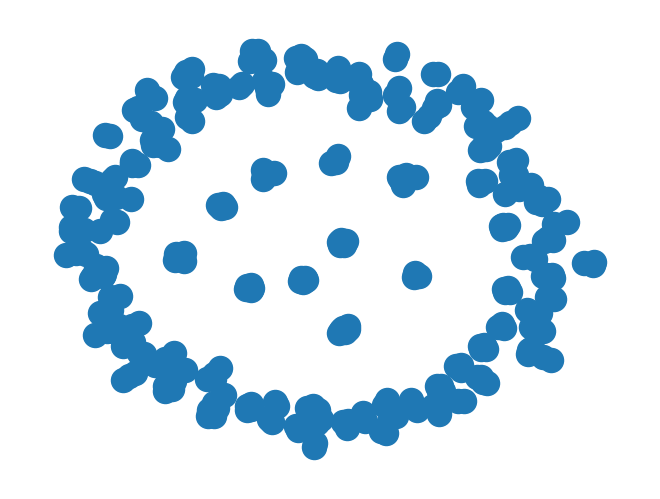

In [24]:
draw(pairs_graph)

In [25]:
from pyjedai.clustering import ConnectedComponentsClustering

In [26]:
ccc = ConnectedComponentsClustering()
clusters = ccc.process(pairs_graph, data)

In [27]:
clusters

[{2613, 4661},
 {1747, 3288, 4489, 4670},
 {1356, 2272, 4676},
 {4122, 4422, 4680},
 {1902, 1909, 2825, 4687},
 {366, 617, 1771, 4699},
 {396, 2562, 4249, 4715},
 {3056, 4721, 4780},
 {2215, 2737, 2755, 4724},
 {3083, 3998, 4409, 4481, 4752, 4769},
 {3011, 3082, 4753},
 {1087, 4063, 4771},
 {368, 1653, 4773},
 {1819, 2338, 4022, 4775},
 {2707, 4488, 4500, 4789},
 {432, 586, 626, 2136, 4790, 4937},
 {3690, 4791},
 {1877, 4805},
 {697, 2882, 4033, 4806},
 {278, 4820},
 {906, 4822},
 {4069, 4828},
 {3, 4373, 4838},
 {163, 4839},
 {2495, 3057, 4844},
 {2358, 4845},
 {1365, 1624, 2421, 4847},
 {1630, 3196, 3575, 4003, 4868},
 {1568, 3118, 3753, 4869},
 {2777, 3912, 4324, 4871},
 {2229, 2456, 4029, 4877},
 {4801, 4894},
 {647, 4129, 4900},
 {239, 1758, 2684, 4568, 4902},
 {2738, 4905},
 {745, 1381, 3839, 4232, 4924},
 {1265, 3623, 4035, 4557, 4932},
 {783, 4268, 4935},
 {448, 1376, 2019, 4945},
 {4138, 4950},
 {2902, 3088, 3305, 3844, 4970},
 {1161, 1636, 2499, 4972},
 {980, 4973},
 {3502, 3

In [28]:
d1['cluster_id'] = None

In [29]:
d1

given_name     surname  street_number             address_1  \
rec_id                                                                
1         mitchell       green              7         wallaby place   
2           harley    mccarthy            177         pridhamstreet   
3         madeline       mason             54       hoseason street   
4         isabelle                         23         gundulu place   
5           taylor    hathaway              7        yuranigh court   
...            ...         ...            ...                   ...   
4996          jack    campbell            169           marr street   
4997       william    lazaroff             12            leah ylose   
4998      destynii    bowerman             12      halford crescent   
4999        gianni      dooley             38     ashburton circuit   
5000          jake   westbrook            231   booroondar a street   

                      address_2           suburb   postcode  state  \
rec_id                                                               
1                        delmar        cleveland       2119     sa   
2                        milton          marsden       3165    nsw   
3        lakefront retrmnt vlge        granville       4881    nsw   
4                     currin ga         utakarra       2193     wa   
5                brentwood vlge                        4220    nsw   
...                         ...              ...        ...    ...   
4996                   rhosewyn         oakleigh       3356    vic   
4997                   milwlood           forbes       7256    qld   
4998                     sutton        nollamara       2431    qld   
4999             brentwood vlge             ryde       6025    qld   
5000                    jodayne   salisbury east       2074    nsw   

        date_of_birth cluster_id  
rec_id                            
1            19560409       None  
2            19080419       None  
3            19081128       None  
4            19921119       None  
5            19991207       None  
...               ...        ...  
4996         19770109       None  
4997                        None  
4998         19880821       None  
4999         19371212       None  
5000         19001115       None  

[5000 rows x 10 columns]

In [30]:
for cluster_id, cluster in enumerate(clusters):
    d1.loc[list(cluster), 'cluster_id'] = cluster_id


In [31]:
d1[pd.notnull(d1['cluster_id'])].head(20)

given_name       surname  street_number            address_1  \
rec_id                                                                   
3           madeline         mason             54      hoseason street   
34              john        slywka             33         gowrie court   
50           charlie         ebert             21       brewster place   
149            riley       wegemer             45       phillip avenue   
152           emiily        vodden             41        clement place   
159             ruby      jeffries             73        forbes street   
163            eliza         white             82   summerland circuit   
165             kate      rawlings             70          corin place   
171         danielle      morrison             95       london circuit   
186            abbey         herno              1        drosera place   
193          charlie     primvaera              6       chauvel street   
197           lauren         paine             27           mcvey pace   
239        charlotte       carbone             12         peppin place   
253      christopher        behnke            378     troughton street   
263             toby        garran              8      mcguiness place   
278                          blyde                      torrens street   
306            white   jean-claude             75      noel ryangarden   
321          zachary          rees              4         hicks street   
344            chloe        arneil            113         pulle street   
366         isabella      theodore            269        churchill way   

                         address_2           suburb   postcode  state  \
rec_id                                                                  
3           lakefront retrmnt vlge        granville       4881    nsw   
34                    boxwood vale       north ward       6014    tas   
50       summerdale medical centre        franskton       4570    vic   
149                       walhalla         cremorne       3937     wa   
152                        arcadia    st johns park       2170    nsw   
159                      underwood        st albans       4165    nsw   
163             rsd shee oak ridge         thornlie       2345    qld   
165                        oxfodrd           kuraby       4216    qld   
171                        sec 552       bibra lake       4701    vic   
186                     quandialla   yarra junction        800    vic   
193                st francis vlge    dover yeights       2533    nsw   
197                        yambira         helid on       2776    qld   
239                                          albury       4559     sa   
253                                        geranium       3496    qld   
263                       the tops            miami       3125    qld   
278                     moorillyah     port augusta       3620    vic   
306                                      glengorwie       7081    nsw   
321                       ferndale           camira       3016    vic   
344                                         belmoot       4883    nsw   
366                         niok a          concord       2446    vic   

        date_of_birth cluster_id  
rec_id                            
3            19081128         22  
34           19590803         57  
50           19711020         59  
149          19540621         88  
152          19811218         55  
159          19490705         51  
163          19420103         23  
165          19330925         64  
171          19030709         95  
186          19760613         90  
193          19250314         48  
197          19440502         53  
239          19171126         33  
253          19080930         56  
263          19520817         48  
278          19650621         19  
306          19400918         63  
321          19660116         87  
344          19951224         94  
366          19711102          5